# TPC1 -  Integração Numérica

<ul>
    <li>Não deve escrever o seu nome nem nenhum código identificador em nenhum sítio. </li>
    <li>Deve entregar ESTE Notebook de Jupyter.</li>
    <li>O trabalho é individual. Podem e devem haver discussões com colegas mas o resultado entregue é individual. </li>
    <li>Não deve acrescentar ou apagar nenhuma célula. </li>
    <li>Todas as explicações devem ser claras e concisas. </li>
    <li>É preferível fazer menos e fazer bem que muito e mal. </li>
    <li>O método @jit(nopython=True) do pacote numba pode diminuir o tempo de cálculo.</li>
    <li>A não verificação de alguma destas regras leva ao anulamento e exclusão da prova.</li>
</ul>


In [39]:
# Introduza o codigo geral aqui
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# 1. Série de Fourier

Uma função diz-se periódica se para todos os valores de $x$ verifica-se que $f(x+L)=f(x)$. Estas funções podem ser expressas à custa de uma base de funções periódicas, 
\begin{align}
f(x)=\sum_{n=-\infty}^{+\infty}c_{n}e^{ik_{n}x}
\end{align}
com os valores $k_{n}=2\pi n/L$ e os coeficientes $c_{n}$ dados por 
\begin{align}
c_{n}=\frac{1}{L}\int_{0}^{L}dxf(x)e^{-ik_{n}x}.
\end{align}
Esta expansão chama-se uma série de Fourier e pode ser entendida como decomposição numa base infinita de funções designadas por,
\begin{align}
\phi_{n}(x)=e^{ik_{n}x}
\end{align}
e na qual podemos definir um produto interno entre duas funções $f(x)$ e $g(x)$ como,
\begin{align}
f\cdot g=\frac{1}{L}\int_{0}^{L}dxf^{*}(x)g(x).
\end{align}
Com esta interpretação os coeficientes $c_{n}$ podem ser compreendidos como as projecções de uma função em cada elemento da base. 

1. Mostre analiticamente a ortogonalidade dos elementos da base, ou seja $\phi_{n}\cdot\phi_{m}=\delta_{mn}$.

# Resposta 1.1

Como as funções $\phi_n$ formam uma base ortonormada temos que:

$$
\phi_n \cdot \phi_m = \delta_{mn}
$$

Onde $\delta_{mn}$ é o delta de Kronecker:

$$
\delta_{mn} = \begin{cases}
0 &\text{se } m \ne n
\\
1 &\text{se } m = n
\end{cases}
$$

Vamos verificar:

$$
\begin{align*}
\phi_n \cdot \phi_m &= \frac 1L\int_0^L \phi_n^*\phi_m\ dx =
\\\\
&= \frac 1L\int_0^L e^{-ik_nx}e^{ik_mx}\ dx =
\\\\
&= \frac 1L\int_0^L e^{2\pi ix(m - n)/ L}\ dx =
\\\\
&= \begin{cases}
\frac 1L\left[\frac{L}{2\pi i(m-n)}e^{2\pi ix(m - n)/ L}\right]_0^L &\text{se } m \ne n
\\\\
\frac 1L\int_0^L e^{0}\ dx  &\text{se } m = n
\end{cases}
\\\\
&= \begin{cases}
\frac{1}{2\pi i(m-n)}\left[\left(e^{2\pi i}\right)^{(m - n)} - e^{0}\right] &\text{se } m \ne n
\\\\
1 &\text{se } m = n
\end{cases}
\\\\
&= \begin{cases}
0 &\text{se } m \ne n
\\\\
1 &\text{se } m = n
\end{cases} =
\\\\
&= \delta_{mn}
\end{align*}
$$

2. Mostre analiticamente que assumindo a equação de expansão se pode verificar que $f(x)=f(x+L)$ para todo o $x$ para $k_{n}=2\pi n/L$.

# Resposta 1.2

Vamos verificar que qualquer função que pode ser descrita pela equação (1.1) é periódica e de período $L$:

$$
\begin{align*}
f(x) &= \sum_{n=-\infty}^{+\infty} c_ne^{ik_nx}
\\\\
f(x + L) &= \sum_{n=-\infty}^{+\infty} c_ne^{ik_n(x+L)} =
\\\\
&= \sum_{n=-\infty}^{+\infty} c_ne^{ik_nx}e^{ik_nL} =
\\\\
&= \sum_{n=-\infty}^{+\infty} c_ne^{ik_nx}e^{2\pi in} =
\\\\
&= \sum_{n=-\infty}^{+\infty} c_ne^{ik_nx}\left(e^{2\pi i}\right)^n =
\\\\
&= \sum_{n=-\infty}^{+\infty} c_ne^{ik_nx} =
\\\\
&= f(x)
\end{align*}
$$

3. Construa uma função que calcule uma série de coeficientes de Fourier para uma função arbitrária usando o método de Simpson. A função deve receber como argumentos pelo menos o parâmetro $L$, um array de $k_{n}$ e o número de intervalos de integração. 

# Resposta 1.3

Podemos notar que:

$$
\begin{align*}
k_n &= \frac{2\pi}{L}n
\\\\
k_{-n} &= \frac{2\pi}{L}(-n) = -k_n
\end{align*}
$$


Para uma função real temos então:

$$
\begin{align*}
c_n &= \frac1L\int_0^L f(x)e^{-ik_nx}\ dx
\\\\\\
c_{-n} &= \frac1L\int_0^L f(x)e^{-ik_{-n}x}\ dx =
\\\\
&= \frac1L\int_0^L f(x)e^{ik_{n}x}\ dx =
\\\\
&= \left(\frac1L\int_0^L f(x)e^{-ik_{n}x}\right)^*\ dx =
\\\\
&= c_n^*
\end{align*}
$$

In [40]:
def fourier_coef(L: float, M: int, func: Callable, kk=[], nmin=0, nmax=0) -> np.ndarray:
    """
        Calcula os coeficientes de Fourier usando o método de Simpson

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função cujos coeficientes queremos calcular
        kk: Array (ou lista) de kn correspondentes aos períodos dos cn que queremos calcular
        nmin, nmax: Intervalo de valores a usar para calcular kk caso este array não seja dado
    """

    # Construir o array kn se especificarmos uma gama de coeficientes em vez de dar os kn
    if len(kk) == 0:
        kk = 2 * np.pi * np.arange(nmin, nmax) / L

    # Parâmetros do Integral
    start = 0
    end = L

    # Intervalos
    h = (end - start) / M
    xx = np.linspace(start, end, M + 1)

    # Pesos de Simpson
    wn = np.ones(M + 1)
    wn[0] = 1/3
    wn[-1] = 1/3
    wn[1:M:2]= 4/3
    wn[2:M:2] = 2/3

    # Função com pesos
    ff = func(xx) * wn
    ff = ff[:, np.newaxis]

    # Fazer broadcasting para obter o produto k * x 
    xx = xx[:, np.newaxis]
    xxkk = xx * kk
    ee = np.exp(-1j * xxkk)

    # Calcular o integral
    yy = ff * ee
    cn = h * yy.sum(axis=0) / L

    return cn


def fourier_coef_real_n(L: float, M: int, func: Callable, N: int) -> np.ndarray:
    """
        Devolve os coeficientes de uma função real até ordem N (inclusive)

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real cujos coeficientes queremos calcular
        N: Ordem até à qual queremos calcular os coeficientes
    """

    # Calculamos os coeficientes de indíces em [0, N]
    cn = fourier_coef(L, M, func, [], 0, N + 1)
    cni = np.flip(cn)

    # Determinamos os coeficiente de indíces em [-N, -1] tomando o conjugado
    cn = np.delete(cn, 0)
    cni = cni.conjugate()

    # Para uma função real c_n = c_{-n}
    return np.concatenate((cni, cn), axis=None)


# Testar a função
nmin, nmax = -2, 2
L_teste = 2 * np.pi
kn = 2 * np.pi * np.arange(nmin, nmax) / L_teste

def f_teste(x): return np.exp(2j * x)

print(fourier_coef(2 * np.pi, 500, f_teste, [], nmin, nmax + 1))

[4.45199433e-17-2.62379083e-18j 8.10462808e-18-1.99881506e-17j
 1.14241949e-16-1.45651828e-17j 1.07136522e-16-1.89121776e-17j
 1.00000000e+00-6.52256027e-19j]


4. Teste a sua função integrando as funções $f_{1}(x)=\sqrt{x+1}$, $f_{2}(x)=\sin(2\pi x)+x^{2}$ e $f_{3}(x)=\sin^{2}(\pi x)+x$ para $L=1$ e $k_{n}=0$. Calcule os integrais analiticamente e represente o desvio relativo do resultado do integral como função do número do número de intervalos. Escolha potências de dois para número de intervalos e escolha a escala log-log para o gráfico. Discuta o que observa.

# Resposta 1.4

Comçamos por calcular os integrais pedidos (que correspondem ao valor médio de cada função em $[0, 1]$):

$$
\begin{align*}
\int_0^1 f_1(x)e^{i0x}\ dx &= \int_0^1 \sqrt{x+1}\ dx =
\\\\
&= \left[\frac23(x+1)^{3/2}\right]_0^1 =
\\\\
&= \frac43\sqrt 2 - \frac23
\\\\\\
\int_0^1 f_2(x)e^{i0x}\ dx &= \int_0^1 \sin(2\pi x) + x^2\ dx =
\\\\
&= 0 + \left[\frac13x^3 \right]_0^1 =
\\\\
&= \frac13
\\\\\\
\int_0^1 f_3(x)e^{i0x}\ dx &= \int_0^1 \sin^2(\pi x) + x\ dx =
\\\\
&= \int_0^1\frac{1 - \cos(2\pi x)}{2} + x\ dx =
\\\\
&= \frac12 - 0 + \frac12 =
\\\\
&= 1
\end{align*}
$$

Vamos agora calcular estes coeficientes de Fourier ($c_0$) usando o método desenvolvido acima e estudar como evolui o erro com o aumento do número de passos.

## Análise dos Resultados

### Função $f_1$

Vemos que no primeiro caso o erro diminui com o aumento do número de intervalos, como seria de esperar no método de Simpson, onde o erro é proporcional a $h^4$, pelo que:

$$
\begin{align*}
\text{Erro} \propto h^4 &\leftrightarrow \log(\text{Erro}) \propto \log\left(\frac1{N^4}\right) \leftrightarrow
\\\\
&\leftrightarrow \log(\text{Erro}) \propto -4\log(N)
\end{align*}
$$

Ou seja, obtemos uma reta com declive negativo. Olhando para os pontos do gráfico que têm abcissas de $10^{0}$ até $10^{-3}$ vemos que o erro diminui de cerca de $10^{-4}$ para cerca de $10^{-16}$, o que de facto corresponde a um declive de cerca de -4.

Notamos também que o erro não diminui abaixo de cerca de $10^{-16}$, pois este é a precisão máxima dos números com ponto flutuante com precisão `double`, que são os usados pelo Python.

Percebemos que para esta função $M = 1000$ é suficiente para atingir a precisão máxima do método implementado em Python (pelo menos para esta função), o que é abaixo da ordem de grandeza estimada teoricamente de $M = 10^4$.


### Função $f_2$

Notamos que para alguns pontos o erro é 0, daí não aparecer no gráfico! Isto acontece pois:
- O método de Simpson aproxima a função como uma sucessão de polinómios de grau 2 e a função $f_2$ é a soma de um polinómio de grau dois com uma função seno de período $1$.
- A função seno de período $1$ é simétrica em torno de $x = 0.5$ e para cada ponto da forma $x = 0.5 + nh$ em que avaliamos o seno também o avaliamos em $x = 0.5 - nh$ (podemos percebê-lo porque ao dividir o intervalo em 2 sucessivamente uma das divisões fica em $x = 0.5$ e o número de divisões à esquerda e à direita de $0.5$ é igual)
.

Para mais intervalos temos erro da ordem de $10^{-16}$, o que se deve à presença de erros de arredondamento.


### Função $f_3$

No terceiro gráfico temos em geral o mesmo comportamento que no segundo, pois esta função é a soma de uma função periódica com um polinómio de grau 1, cujo integral é calculado de forma exata pela regra de Simpson.

Dito isto, notamos que há muitos mais pontos nos quais o erro é nulo para $f_3$ do que para $f_2$. Isto pode-se dever ao facto de:
- O resultado do integral de $f_2$ ser $1/3$, que não pode ser representado exatamente em binário (tal como não o pode ser em decimal).
- O resultado do integral de $f_3$ ser $1$, que já pode ser representado exatamente em binário, pelo que os erros de arredondamento ao comparar com o valor real podem ser evitados.

Notamos também que para $N = 2$ o erro é muito maior, o que podemos verificar calculando o integral usando a regra de Simpson analiticamente:

$$
\begin{align*}
I_S\left(0, 1, \frac12, f\right) &= \frac13\cdot\frac12\left[f(0) + 4f\left(\frac12\right) + f(1)\right] =
\\\\
&= \frac16 \cdot \left[0 + 4 \cdot \frac32 + 1\right] =
\\\\
&= \frac76
\end{align*}
$$

Olhando para o array com os desvios, podemos verificar que este o desvio para $N=2$ (primeiro elemento do array) é de facto:

$$
\frac76 - 1 = \frac16
$$

Visualmente, este erro pode ser percebido pelo facto de a parábola que aproxima a função ser sempre superior à função.

Desvios de $f_1$:
[7.04773844e-05 5.13526650e-06 3.37264988e-07 2.13685335e-08
 1.34022667e-09 8.38382037e-11 5.24111731e-12 3.27706452e-13
 2.05841185e-14 1.45728272e-15 1.82160340e-16 1.82160340e-16
 1.82160340e-16 1.82160340e-16 1.82160340e-16] 

Desvios de $f_2$:
[1.66533454e-16 0.00000000e+00 1.66533454e-16 0.00000000e+00
 0.00000000e+00 1.66533454e-16 1.66533454e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.66533454e-16 0.00000000e+00
 1.66533454e-16 1.66533454e-16 0.00000000e+00] 

Desvios de $f_3$:
[1.66666667e-01 0.00000000e+00 1.11022302e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.11022302e-16 0.00000000e+00 0.00000000e+00] 

Desvios de $f_3$ (excluindo o primeiro ponto):
[0.00000000e+00 1.11022302e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.11022302e-16
 0.00000000e+00 0.00

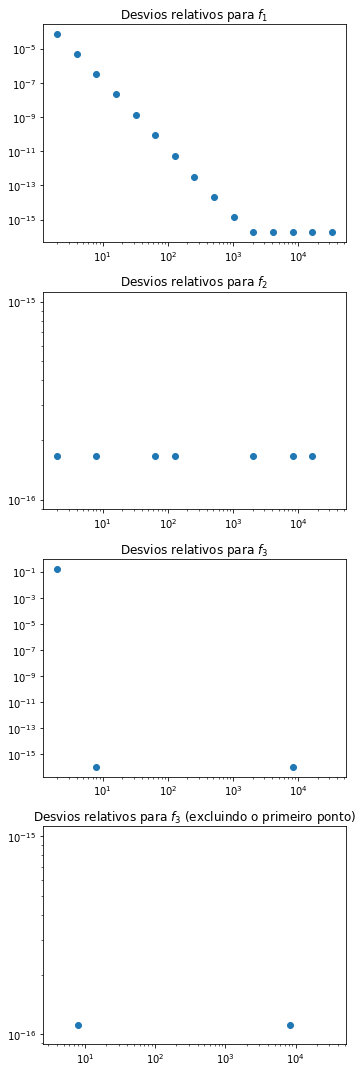

In [41]:
# Definir funções do exercício 1
L1 = 1

correto1 = (4/3) * 2**0.5 - (2/3)
def f11(x: float) -> float:
    return (x + 1)**0.5


correto2 = 1/3
def f12(x: float) -> float:
    return np.sin(2 * np.pi * x) + x**2


correto3 = 1
def f13(x: float) -> float:
    return (np.sin(np.pi * x))**2 + x


def plot_erros(L: float, correto: float, func: Callable, nome: str, pos: tuple[int, int, int], MMin=1, MMax=16) -> None:
    """
        Representa graficamente o erro do cálculo do integral de uma função

        L: Limite do integral (o integral é feito de 0 a L)
        correto: Valor real do integral (habitualmente determinado via analítica)
        func: Função real cujo integral queremos calcular
        nome: Nome da função que vai aparecer no gráfico
        pos: Posição do gráfico na subplot, onde pos[0] são as linhas, pos[1] são as colunas e pos[2] é o indíce do gráfico
        MMin, MMax: Valores mínimos e máximos dos expoentes de 2 usados para o número de intervalos da regra de Simpson
    """
    
    # Número de intervalos
    Marr = 2 ** np.arange(MMin, MMax)
    desvios = np.zeros((MMax - MMin))

    # Calcular o integral
    for index, M in enumerate(Marr):
        c0 = fourier_coef_real_n(L, M, func, 0)[0].real
        desvios[index] = abs((c0 - correto) / correto)
    
    # Fazer o gráfico
    plt.subplot(pos[0], pos[1], pos[2])
    plt.scatter(Marr, desvios)
    plt.title(f"Desvios relativos para {nome}")
    plt.xscale("log")
    plt.yscale("log")
    
    # Mostrar os desvios
    print(f"Desvios de {nome}:")
    print(desvios, "\n")

    return

# Parâmetros
rows = 4
cols = 1

plt.figure(figsize=(5, 15))
plot_erros(L1, correto1, f11, "$f_1$", (rows, cols, 1))
plot_erros(L1, correto2, f12, "$f_2$", (rows, cols, 2))
plot_erros(L1, correto3, f13, "$f_3$", (rows, cols, 3))
plot_erros(L1, correto3, f13, "$f_3$ (excluindo o primeiro ponto)", (rows, cols, 4), MMin=2)
plt.tight_layout()
plt.show()

<div style="border:1px solid black;">
<span style="color:red; font-weight:bold;">Nota:</span> 1
<br><div style="color:red; font-weight:bold;">Comentário:</div> Exercicio extremamente bem feito, explicado, e muito completo com todas as informações relevantes para mostrar o raciocínio e a compreensão do problema, perceber o código, e no 1.4 ainda explicar com muito detalhe o observado nos gráficos obtidos relativamente às 3 funções dadas.
    
    - Em 1.1 e 1.2, fez corretamente as demonstrações pedidas: mostrar a ortogonalidade dos elementos da base, e a periodicidade da função. 
    - Em 1.3, calculou os coeficientes de fourier de uma função arbitrária, usando como argumentos da função, por ordem: Limite de integração (L), Número de intervalos (M), função arbitrária (f = 1), array k_n, e ainda definiu uns valores nmin e nmax que ele definiu caso k_n não fosse definido.
    - Em 1.4, calculou primeiramente os integrais analiticamente, e fez uma função com intervalos de potências de base 2, onde calculou para cada valor, o seu respetivo desvio usando a função da alínea anterior. Representou todos os desvios calculados e a sua respetiva representação gráfica em função do número de intervalos definido. Em cima, explica adequadamente o observado e explica-o de acordo com os seus conhecimentos relativos à integração segundo o método de simpson.
    
<div style="border:1px solid black;">
<span style="color:red; font-weight:bold;">Nota:</span> 1
<br><div style="color:red; font-weight:bold;">Comentário:</div> Nas duas primeiras alíneas do problema 1 chegou-se ao resultado pretendido. Na pergunta 1.3 é implementado corretamente o método de simpson. Na pergunta 1.4 antes de se fazer o run inicial do notebook, apareciam os gráficos representados, mostrando um comportamento próximo do esperado para o problema. No entanto, depois de se fazer 'restart kernel and run all', apareceu uma mensagem de erro (TypeError: 'type' object is not subscriptable), que mesmo depois de ser corrigida, através de na função plot_erros se mudar o argumento de 'pos:tuple[int,int,int]' para 'pos:tuple=[int,int,int]', mostrou um output diferente do inicial. No entanto, a explicação do que acontece para cada uma das funções foi bem elaborada.
 </div>


# Aproximação de funções com série finita

Numericamente não podemos somar uma série infinita, logo, temos limitar a série a um número máximo de valores de n. Com a série limitada a aproximação de ordem N de uma função será dada por, \begin{align}
f_{N}(x)=\sum_{n=-N}^{N}c_{n}e^{ik_{n}x}.
\end{align}

1. Considere a função periódica 
\begin{align}
f(x)=e^{-40(1-\sin^{2}(\pi x))}
\end{align}
de período $L=1$.

(a) Represente a função e as respectivas aproximações de Fourier para valores de N escolhidos entre potências de dois (\{2,4,8,16,32,64,128\}). Sugestão: Como a aproximação de Fourier poderá ter parte imaginária represente em dois gráficos diferentes a parte real e parte imaginária - faça isto sempre que for necessário.

# Resposta 2.1 a)

## Análise dos Resultados

Através dos resultados abaixo podemos perceber que:
- A aproximação de Fourier converge rapidamente para a função. A partir de $N=16$ já temos uma boa aproximação da função!
- A parte imaginária da série de Fourier é sempre aproximadamente nula, sendo o seu valor inferior à precisão numérica do Python, cerca de $10^{-16}$.

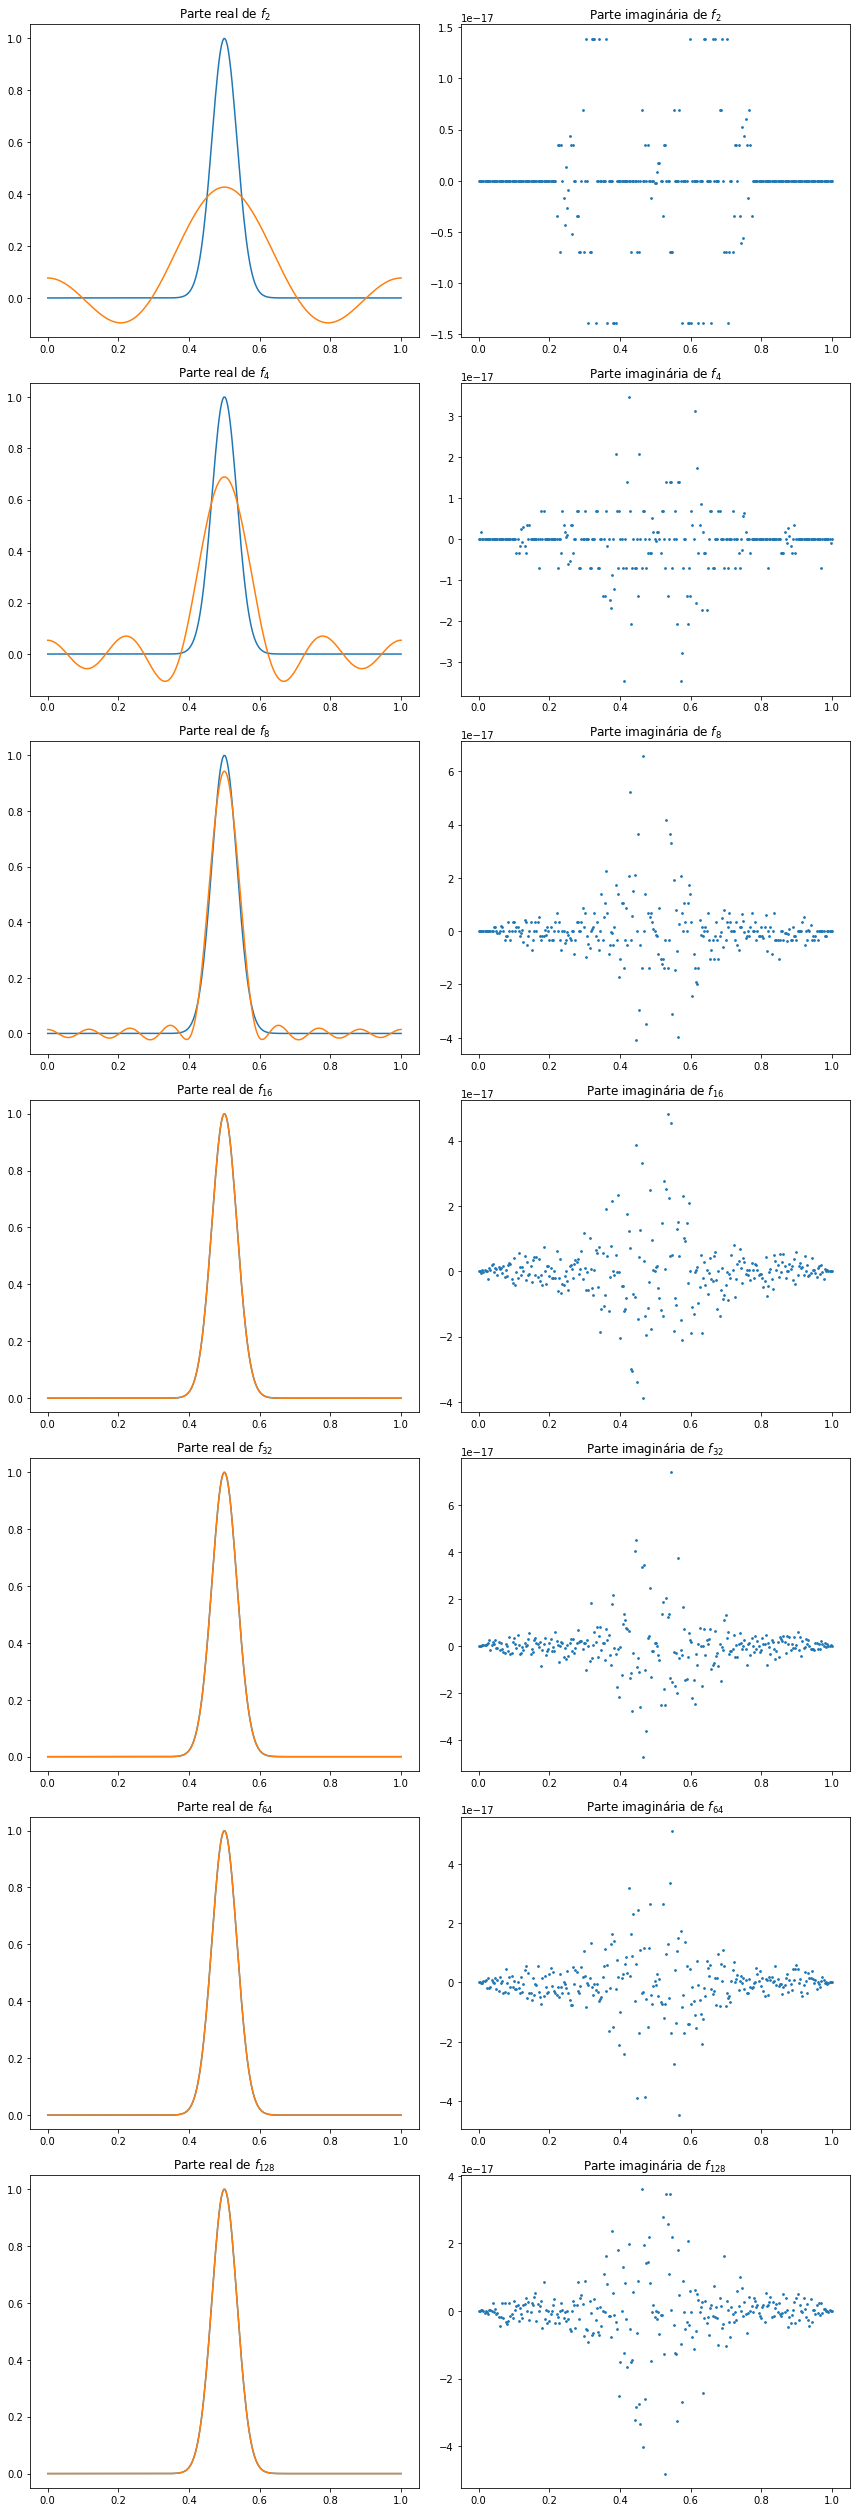

In [42]:
# Definir a função do exercício 2.1

L = 1
def f21(x: float) -> float:
    return np.e**(40 * ((np.sin(np.pi*x))**2 - 1))


def fourier_aprox(cn: np.ndarray, kn: np.ndarray, N: int, n: int) -> Callable:
    """
        Reconstruir uma função a partir dos seus coeficentes de Fourier

        cn: Array com coeficientes de Fourier
        kn: Array com frequências associadas a cada coeficiente
        N: Número total de coeficientes (temos coeficientes de -N a N)
        n: Ordem da aproximação (usamos coeficientes de -N a N)
    """
    return lambda x: sum([cn[N + i] * np.e**(1j * kn[N + i] * x) for i in range(-n, n+1)])


def plot_fourier_n(L:float, M: int, func: Callable, NN: np.ndarray, P: int, rows: int, cols: int, start=0.0, end=1.0) -> None:
    """
        Representar graficamente uma função e a sua aproximação de Fourier de ordem N

        L: Período da função func (a função será representada de 0 a L)
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real cujos coeficientes queremos calcular
        N: Ordem da aproximação (coeficientes de -N a N)
        P: Número de pontos a usar na representação gráfica
        rows: Número de linhas no subplot
        cols: Número de colunas no subplot
        start: Início do gráfico (em unidades de L)
        end: Fim do gráfico (em unidades de L)
    """

    # Obter os coeficientes de Fourier que vamos usar
    N = max(NN)
    cn = fourier_coef_real_n(L, M, func, N)
    kn = 2 * np.pi * np.arange(-N, N + 1) / L

    # Pontos que vamos usar
    xx = np.linspace(L*start, L*end, P)
    ff = func(xx)


    # Obter a função aproximada
    plt.figure(figsize=(6 * cols, 5 * rows))
    for i, n in enumerate(NN):
        aprox_func = fourier_aprox(cn, kn, N, n)
        aa = aprox_func(xx)

        plt.subplot(rows, cols, 2*i+1)
        plt.plot(xx, ff)
        plt.title(f"Parte real de $f_{{{n}}}$")
        plt.plot(xx, aa.real)

        plt.subplot(rows, cols, 2*i+2)
        plt.title(f"Parte imaginária de $f_{{{n}}}$")
        plt.scatter(xx, aa.imag, s=3)

    plt.tight_layout()
    plt.show()

    return None


# Parâmetros
M = 1000
P = 300

NMin = 1
NMax = 7
NN = 2 ** np.arange(NMin, NMax + 1)

rows = NMax - NMin + 1
cols = 2

# Fazer os gráficos
plot_fourier_n(L, M, f21, NN, P, rows, cols)

(b) Para discutir a qualidade da aproximação podemos medir o desvio entre a função e a aproximação. Para este efeito, considere a grandeza,
\begin{align}
D_{N} &= \frac{\int_{0}^{L}dx\sqrt{\left|f(x)-f_{N}(x)\right|^{2}}}{\int_{0}^{L}dxf(x)}.
\end{align}
Represente os desvios $D_{N}$ para números inteiros consecutivos desde $0\le N<128$. Discuta o que observa e interprete os resultados.

# Resposta 2.1 b)

## Análise dos Resultados

Como seria de esperar, ao usar mais termos da série de Fourier para aproximar a função $f$ os desvios diminuem, mas a partir de um certo ponto parece que o erro começa a subir.

A pricípio o erro mínimo atingido é da ordem dos erros de arredondamento, sendo chega a ser da ordem de $10^{-14}$. Pode estar a haver um acumular de erros de arredondamento porque estmos a calcular integrais com muitos passos e a usar esses resultados em novos cálculos.

**Nota**: A discussão dos erros aqui observados continua na alínea 2.1 c), já que podemos comparar este gráfico com o gráfico aí obtido.

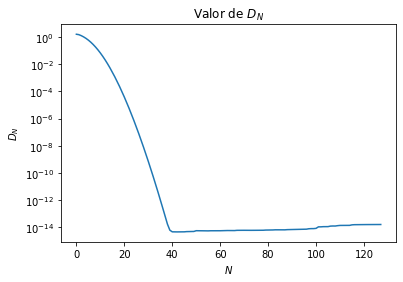

O menor desvio foi de 4.617e-15.
O maior desvio após termos atingido o mínimo foi de 1.622e-14.


In [43]:
def simpson(start: float, end: float, func: Callable, M: int) -> float:
    """
        Regra de Simpson para M passos

        start: Limite inferior do integral
        end: Limite superior do integral
        func: Função a integrar
        M: Número de intervalos usados no método de Simpson (M é par!)
    """

    # Abcissas
    h = (end - start) / M
    tt = np.linspace(start, end, M + 1)
    vv = func(tt)

    # Área segmentos
    aa = vv[:-2:2] + 4 * vv[1:-1:2] + vv[2: :2]
    integral = aa.sum()

    return h * (integral) / 3


def distf(func1: Callable, func2: Callable) -> Callable:
    """
        Distância entre duas funções

        func1: Primeira função
        func2: Segunda função
    """
    
    return lambda x: abs(func1(x) - func2(x))


def fourier_multi(L: float, M: int, func: Callable, NN: np.ndarray) -> np.ndarray:
    """
        Fazer múltiplas aproximações de Fourier de uma função

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real cujos coeficientes queremos calcular
        NN: Ordens até onde queremos calcular os coeficientes
    """

    # Calcular todos os coeficientes de Fourier que vamos precisar
    N = max(NN)
    kn = 2 * np.pi * np.arange(-N, N + 1) / L
    cn = fourier_coef_real_n(L, M, func, N)

    # Somar os termos até ordem n
    return np.array([fourier_aprox(cn, kn, N, n) for n in NN])


# Calcular desvio relativo
def fourier_desvios(L: float, M: int, func: Callable, NN: np.ndarray) -> np.ndarray:
    """
        Calcular os desvios entre uma função e as suas aproximações de Fourier

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real cujos coeficientes queremos calcular
        NN: Ordens para as quais queremos calcular os desvios
    """

    # Função f e aproximações de Fourier
    intf = simpson(0, L, func, M)
    afaf = fourier_multi(L, M, func, NN)

    # Desvios
    return np.array([simpson(0, L, distf(func, af), M) / intf for af in afaf])


# Parâmetros
M = 1000

NMin = 0
NMax = 128
NN = np.arange(NMin, NMax)

# Obter os desvios
df = fourier_desvios(L, M, f21, NN)

# Fazer o gráfico
plt.plot(NN, df)
plt.title("Valor de $D_N$")
plt.xlabel("$N$")
plt.ylabel("$D_N$")
plt.yscale("log")
plt.show()

# Desvios importantes
mini = min(df)
maxi = max(df[list(df).index(mini) + 1:])

print(f"O menor desvio foi de {mini:.3e}.")
print(f"O maior desvio após termos atingido o mínimo foi de {maxi:.3e}.")

(c) Em 1799 Parseval apresentou o teorema, 
\begin{align}
\sum_{n\in\mathbb{Z}}b_{n}^{*}a_{n}=\frac{1}{L}\int_{0}^{L}dxB^{*}(x)
\end{align}
$A(x)$onde $a_{n}$ e $b_{n}$ são respectivamente os coeficientes da decomposição de Fourier das funções $B(x)$ e $A(x)$. Uma aplicação possível é ver que a norma das duas representações deste objecto é conservada, 
\begin{align}
\sum_{n\in Z}\left|c_{n}\right|^{2}=\frac{1}{L}\int_{0}^{L}dx\left|f(x)\right|^{2}
\end{align}
quando limitamos a série a um número de termos finitos, podemos aferir a componente que falta calculando a diferença relativa,
\begin{align}
P_{M}=\left|1-\frac{\sum_{n=-M}^{M}\left|c_{n}\right|^{2}}{\frac{1}{L}\int_{0}^{L}dx\left|f(x)\right|^{2}}\right|.
\end{align}
Represente $P_{M}$ como função de $M$ e comente os resultados.

# Resposta 2.1 c)

Vamos começar por reescrever:

$$
P_N = \left|1 - L\frac{\sum_{n=-N}^N |c_n|^2}{\int_0^L |f(x)|^2\ dx}\right|
$$

## Análise dos Resultados
Observamos um comportamento muito semelhante ao que vemos na alínea b), sendo que agora n~ao notamos um acumular do erro à medida que aumentamos o valor de $N$.

Isto pode-se dever ao numerador de $D_N$, que envolve uma diferença de dois valores muito próximos! Assim, como já vimos, este cálculo pode ter um erro relativo significativamente maior quando comparado com outras operações.

Como $P_N$ apenas envolve somas, este problema deixa de estar presente!

**Nota**: Usei $P_N$ em vez de $P_M$ para continuar a usar $M$ como o número de intervalos na regra de Simpson.

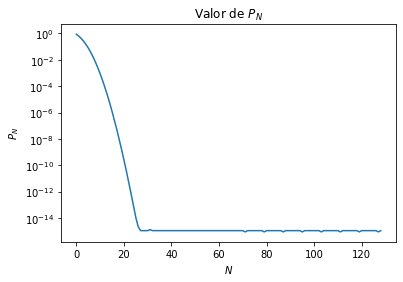

In [44]:
def fourier_faltam(L: float, M: int, func: Callable, NN: np.ndarray) -> np.ndarray:
    """
        Calcular a parte que falta

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real cujos coeficientes queremos calcular
        NN: Ordens para as quais queremos calcular P_N
    """

    # Calcular todos os coeficientes de Fourier que vamos precisar
    N = max(NN)
    cn = fourier_coef_real_n(L, M, func, N)

    # Integral de f^2
    intf2 = simpson(0, L, lambda x: abs(func(x))**2, M)

    # Partes que faltam
    return np.array([abs(1 - L * ((abs(cn[N-n:N+n+1])**2).sum() / intf2)) for n in NN])


# Calcular as componentes que faltam
NMin = 0
NMax = 129
NN = np.arange(NMin, NMax)
pn = fourier_faltam(L, M, f21, NN)


plt.plot(NN, pn)
plt.title("Valor de $P_N$")
plt.xlabel("$N$")
plt.ylabel("$P_N$")
plt.yscale("log")
plt.show()

2. Repita a análise anterior para a função 
\begin{align}
f(x)=\begin{cases}
1 & 0\le mod(x,1)<0.5\\
0 & 0.5\le mod(x,1)\le1
\end{cases}
\end{align}
onde $mod(x,1)=x-int(x)$ corresponde à função resto. Neste caso surge o fenómeno de oscilações de Gibbs investigue o seu significado e discuta-o usando as ferramentas introduzidas neste problema. 

# Resposta 2.2

## Análise dos Resultados a)

Os resultados são semelhantes aos da alínea 2.1, sendo que agora é visível o facto de a série convergir mais lentamente para função. Isto deve-se ao facto de esta função ter uma descontinuidade relativamente grande.

## Análise dos Resultados b)

Podemos calcular os coeficientes da série de Fourier analiticamente para perceber a forma do gráfico dos desvios:

$$
\begin{align*}
c_n &= \frac1L\int_0^L f(x)e^{-ik_nx}\ dx
\\\\
&= \int_0^{\frac12} e^{-i2\pi nx}\ dx =
\\\\
&= \begin{cases}
\frac12 &\text{se } n = 0
\\\\
-\frac{1}{2\pi ni}\left[e^{-i2\pi nx}\right]_0^{\frac12}  &\text{se } n \ne 0
\end{cases} =
\\\\
&= \begin{cases}
\frac12 &\text{se } n = 0
\\\\
\frac{i}{2\pi n}\left[e^{-i\pi n} - 1\right] &\text{se } n \ne 0
\end{cases} =
\\\\
&= \begin{cases}
\frac12 &\text{se } n = 0
\\\\
0 &\text{se } n \text{ for par e diferente de 0}
\\\\
-\frac{i}{\pi n} &\text{se } n \text{ for ímpar}
\end{cases}
\end{align*}
$$

Podemos também ver que agora o erro diminui muito mais lentamente do que na alínea 2.1, não chegando a estabilizar junto do valor do erro de precisão numérica do Python! Isto é uma consequência do que já vimos acima, isto é, do facto de a série de Fourier convergir lentamente.

Notamos também que os pontos do desvio estão agrupados dois a dois, ou seja, há termos que não diminuem o erro, como determinamos acima! Como o primeiro termo é $0$ confirmamos também que o erro diminui ao adicionar mais coeficientes de índice ímpar ($1, 3, \dots$).

## Análise c)

De novo, percebemos que o erro diminui lentamente e que há termos que não diminuem o erro!

## Fenómeno de Gibbs

Vemos o fenómento de oscilações de Gibbs em torno da descontinuidade em $x = 0.5$. Este fenómeno consiste no facto de a série de Fourier fazer *overshoot* do valor real da função que está a aproximar junto do ponto de descontinuidade. No limite $N \to +\infty$ o overshoot será de cerca de 8.95% do valor do salto da descontinuidade, sendo que podemos verificar se esse é o caso para $N$ suficientemente grande.

De facto obtemos um valor cerca de 8.95% acima do valor esperado! Para além disso, repetindo o cálculo para uma ordem superior obtemos tendencialmente um máximo mais próximo de 1.089 para um $x$ mais próximo de 0.5 (mas inferior a 0.5).

ALÍNEA a)


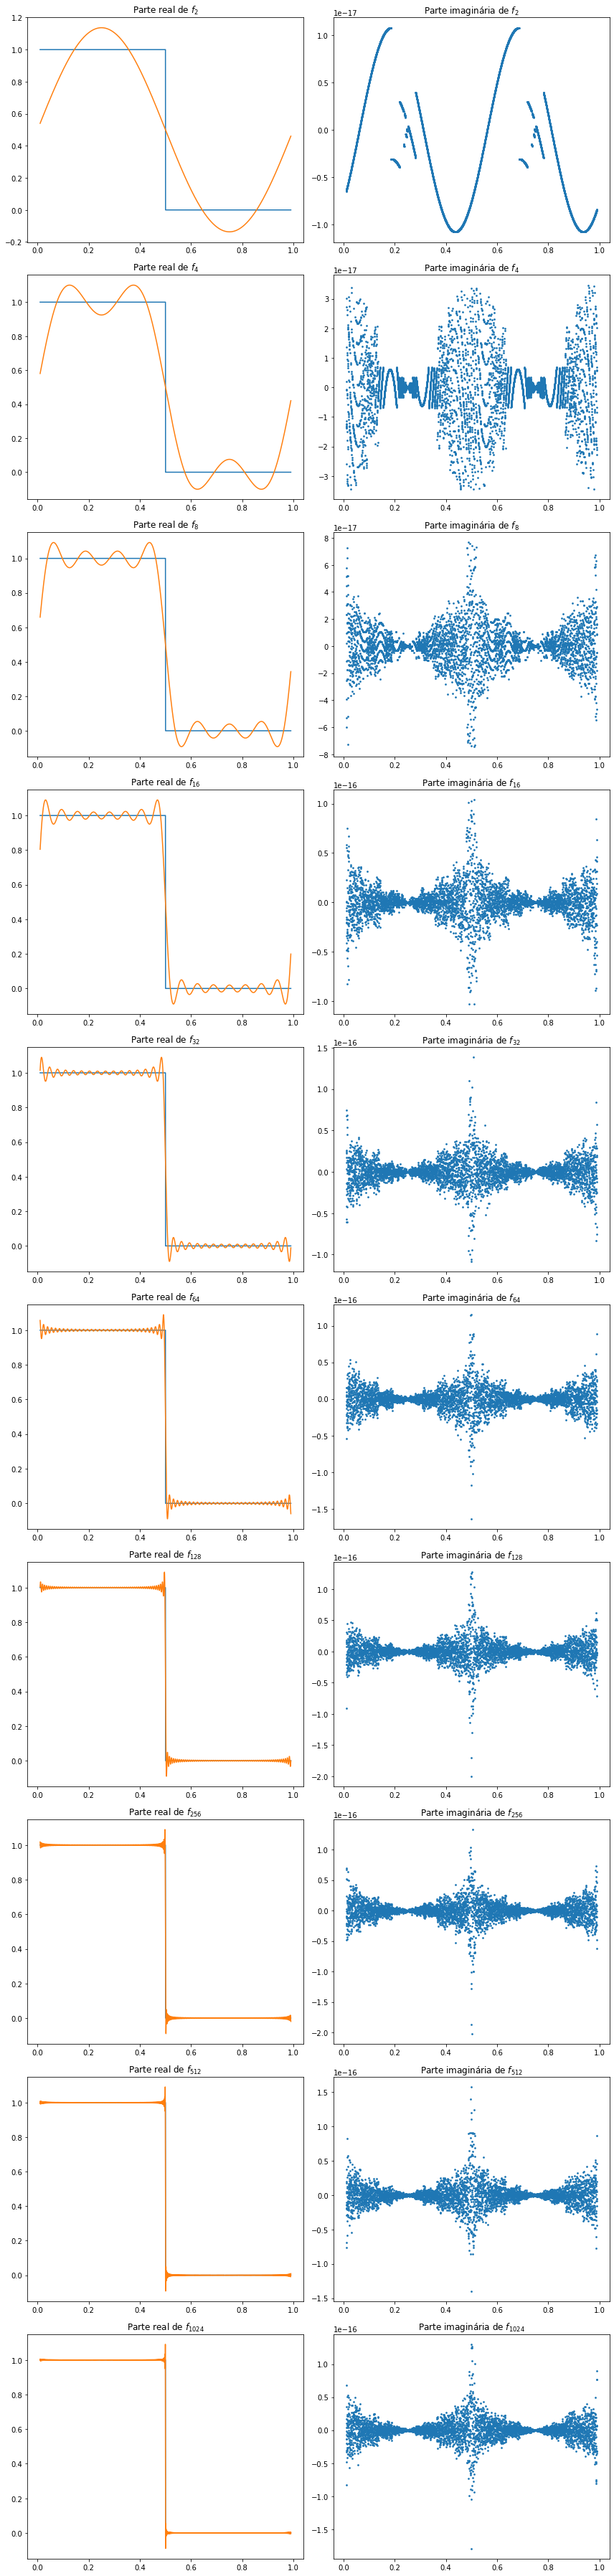

ALÍNEA b)


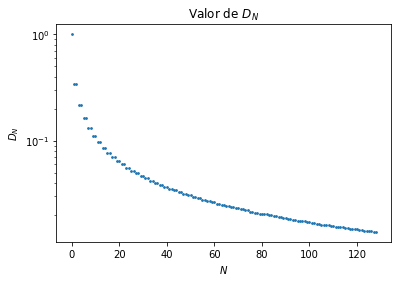

O menor desvio foi de 1.387e-02.
ALÍNEA c)


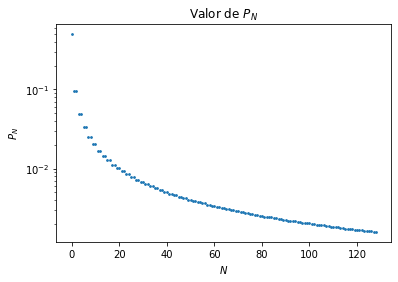

Para a aproximação de ordem 2 o valor máximo junto de 0.5 foi de 0.87358 para x = 0.400
Para a aproximação de ordem 4 o valor máximo junto de 0.5 foi de 1.07563 para x = 0.400
Para a aproximação de ordem 8 o valor máximo junto de 0.5 foi de 1.09211 para x = 0.437
Para a aproximação de ordem 16 o valor máximo junto de 0.5 foi de 1.09015 para x = 0.469
Para a aproximação de ordem 32 o valor máximo junto de 0.5 foi de 1.08968 para x = 0.484
Para a aproximação de ordem 64 o valor máximo junto de 0.5 foi de 1.08963 para x = 0.492
Para a aproximação de ordem 128 o valor máximo junto de 0.5 foi de 1.08965 para x = 0.496
Para a aproximação de ordem 256 o valor máximo junto de 0.5 foi de 1.09076 para x = 0.498


In [45]:
# Função do exercício 2.2 (para x >= 0)
def f22(x: float) -> float:
    dec, _ = np.modf(x)
    dec = 1 - np.floor(2 * dec)
    return dec

# ALÍNEA a) ----------
print("ALÍNEA a)")

# Parâmetros
M = 5000
P = 5000

NMin = 1
NMax = 10
NN = 2 ** np.arange(NMin, NMax + 1)

rows = NMax - NMin + 1
cols = 2

# Fazer os gráficos
plot_fourier_n(L, M, f22, NN, P, rows, cols, start=0.01, end=0.99)



# ALÍNEA b) ----------
print("ALÍNEA b)")

# Parâmetros
NMin = 0
NMax = 129
NN = np.arange(NMin, NMax)

# Obter os desvios
df = fourier_desvios(L, M, f22, NN)

# Fazer o gráfico
plt.scatter(NN, df, s=3)
plt.title("Valor de $D_N$")
plt.xlabel("$N$")
plt.ylabel("$D_N$")
plt.yscale("log")
plt.show()

# Desvios importantes
mini = min(df)

print(f"O menor desvio foi de {mini:.3e}.")



# ALÍNEA c)
print("ALÍNEA c)")

# Obter as componentes que faltam
pn = fourier_faltam(L, M, f22, NN)

# Fazer o gráfico
plt.scatter(NN, pn, s=3)
plt.title("Valor de $P_N$")
plt.xlabel("$N$")
plt.ylabel("$P_N$")
plt.yscale("log")
plt.show()


# FENÓMENO DE GIBBS ----------
M = 3000
P = 5000

NMin = 1
NMax = 8
NN = 2 ** np.arange(NMin, NMax + 1)

x0 = 0.5
dist = 0.1

# Valor máximo da aproximação de Fourier de ordem N junto de x = x0
for N in NN:
    # Abcissas
    xx = np.linspace(0, L, P)

    # Aproximação de Fourier
    cn = fourier_coef_real_n(L, M, f22, N)
    kn = 2 * np.pi * np.arange(-N, N + 1) / L

    fn = fourier_aprox(cn, kn, N, N)
    yy = fn(xx).real

    # Máximo da aproximção perto de 0.5
    maxv = max(yy[abs(xx - x0) < dist])
    maxi = list(yy).index(maxv)

    print(f"Para a aproximação de ordem {N} o valor máximo junto de {x0} foi de {maxv:.5f} para x = {L * (maxi / P):.3f}")

<div style="border:1px solid black;">
<span style="color:red; font-weight:bold;">Nota:</span>
<br><div style="color:red; font-weight:bold;">Comentário:</div> No geral, como no exercício anterior, os gráficos obtidos são os esperados, obtidos através de um código bem estruturado e comentando a funcionalidade de cada função e de seus argumentos, assim como explicando os resultados gerados nos gráficos, em geral, de maneira acertiva.
    
    Em 2.1 a) - código bem feito e explicado, assim como a devida e necessária explicação dos gráficos obtidos. Além disso, o aluno fez questão de representar cada gráfico da parte real e da parte imaginária que corresponde a cada aproximação com cada valor de N utilizado, para observar de maneira mais clara de que forma melhora a aproximação quanto maior for o número N.
    Em 2.1 b) - o gráfico do desvio relativamente ao número N está correto, sendo a variação do desvio o esperado, estabilizando para 10^-14.
    Em 2.1 c) - o gráfico obtido não corresponde ao esperado.
    Em 2.2 - código bem explicado e bem estruturado, os gráficos obtidos são corretos e ainda de salientar a correta e detalhada análise dos gráficos obtidos, para cada um dos valores N usados.<div style="border:1px solid black;">
<span style="color:red; font-weight:bold;">Nota:</span> 1
<br><div style="color:red; font-weight:bold;">Comentário:</div> Grupo globalmente bem executado. Sugeriria que os gráficos fossem legendados, particularmente os da alínea a), visto que quando há sobreposição entre a função original e a função aproximada não se consegue perceber que estão duas funções representadas. O código corre rápido e foi explicado. Na pergunta 2, para a representação do PN não se obteve o esperado, algo próximo do obtido para DN. </div>


# Propagação de ondas numa corda

Considere uma corda fixa pelas extremidades. A equação de movimento da altura em cada posição ($\psi(x,t)$) é dada por
\begin{align}
\frac{\partial^{2}\psi(x,t)}{\partial t^{2}}=c^{2}\frac{\partial^{2}\psi(x,t)}{\partial^{2}x}
\end{align}
onde $c$ é a com a condição fronteira determinada por $\psi(0,t)=\psi(L,t)=0$. 

1. Adimensionalize esta equação de modo a ter todas as quantidades físicas como quantidades adimensionais. 

# Resposta 3.1

Para adimensionalizar a equação consideramos as seguintes quantidades características do problema:
- $L$ $\rightarrow$ Comprimento característico
- $L/c$ $\rightarrow$ Tempo característico

Definimos então as novas variáveis adimensionais abaixo:
- $\chi = x/L$
- $\tau = t/(L/c) = tc/L$

Tal que $\chi \in [0, 1]$. Vamos então reescrever a equação nestas variáveis:

$$
\begin{align*}
\frac{\partial^2\psi(x, t)}{\partial t^2} = c^2\frac{\partial^2\psi(x, t)}{\partial x^2} &\leftrightarrow \frac{\partial^2\psi(L\chi, \tau L/c)}{\partial \tau^2}\frac{c^2}{L^2} = c^2\frac{\partial^2\psi(L\chi, \tau L/c)}{\partial \chi^2}\frac{1}{L^2} \leftrightarrow
\\\\
&\leftrightarrow \frac{\partial^2\Psi(\chi, \tau)}{\partial \tau^2}= \frac{\partial^2\Psi(\chi, \tau)}{\partial \chi^2}
\end{align*}
$$

Onde $\Psi(\chi, \tau) = \psi(L\chi, \tau L/c)$.

----
Chegamos a uma expressão com a mesma forma escolhendo $L=1$ e $c=1$ e limitando $x$ a $[0, 1]$.

Assim, ao longo do exercício vamos usar estas definições para trabalharmos com a equação adimensionalizada.

In [46]:
# Não é necessário código

2. Podemos tratar este problema expandindo a solução em série de Fourier para cada tempo,
\begin{align}
\psi_{N}(x,t)=\sum_{n=-N}^{N}c_{n}(t)e^{ik_{n}x}
\end{align}
e projectando a equação em cada elemento da base de funções $\phi_{m}(x)=e^{ik_{m}x}$, 
\begin{align}
\frac{1}{L}\int_{0}^{L}dx\phi_{m}^{*}(x)\frac{\partial^{2}\psi_{N}(x,t)}{\partial t^{2}}=\frac{c^{2}}{L}\int_{0}^{L}dx\phi_{m}^{*}(x)\frac{\partial^{2}\psi(x,t)}{\partial^{2}x}
\end{align}
obtemos 
\begin{align}
\frac{\partial^{2}c_{m}(t)}{\partial t^{2}}=-c^{2}k_{m}^{2}c_{m}(t). 
\end{align}
Esta equação diferencial para cada modo pode ser resolvida com a solução do tipo
\begin{align}
c_{m}(t)=A_{m}e^{i\omega_{m}t}+B_{m}e^{-i\omega_{m}t}.
\end{align}
Determine o valor de $\omega_{n}$, $A_{m}$ e $B_{m}$ para cada modo como função de $c_{m}(0)$ e $\left.\frac{dc_{m}}{dt}\right|_{t=0}$.

# Resposta 3.2

Como já conhecemos a forma geral da solução da equação diferencial basta usá-la para determinar o valor das constantes e de $\omega_m$:

$$
\begin{align*}
\frac{\partial^2c_m(t)}{\partial t^2} = -c^2k_m^2c_m(t) &\leftrightarrow (i\omega_m)^2A_me^{i\omega_m t} + (-i\omega_m)^2B_me^{-i\omega_m t} = -c^2k_m^2(A_me^{i\omega_m t} + B_me^{-i\omega_m t}) \leftrightarrow
\\\\
&\leftrightarrow -\omega_m^2A_me^{i\omega_m t} -\omega_m^2B_me^{-i\omega_m t} = -c^2k_m^2A_me^{i\omega_m t} -c^2k_m^2B_me^{-i\omega_m t}
\end{align*}
$$
Usando a ortogonalidade das exponenciais (que verificamos no exercício 1.1) e escrevendo $c=1$ temos que:

$$
\omega_m = k_m \quad\rightarrow\quad c_m(t) = A_me^{ik_mt} + B_me^{-ik_mt}
$$

Avaliando agora a solução e respetiva derivada:
$$
\begin{align*}
\begin{cases}
c_m(0) &= A_me^{ik_m0} + B_me^{-ik_m0}
\\\\
\left.\frac{dc_m}{dt}\right.\vert_{t=0} &= ik_mA_me^{i\omega_m0} -ik_mB_me^{i\omega_m0}
\end{cases} \quad&\leftrightarrow \begin{cases}
c_m(0) &= A_m + B_m
\\\\
c_m'(0) &= ik_m(A_m -B_m)
\end{cases} \leftrightarrow
\\\\
&\leftrightarrow \begin{cases}
A_m &= \frac12\left[c_m(0) +\frac{c'_m(0)}{ik_m}\right]
\\\\
B_m &= \frac12\left[c_m(0) -\frac{c'_m(0)}{ik_m}\right]
\end{cases} \text{ se } m \ne 0 
\end{align*}
$$

Para $m = 0$ temos que $c_0(t) = c_0(0)$ e $c_0'(t) = 0$.

----
Temos então:

$$
\begin{align*}
c_m(t) &= \frac12\left[c_m(0) +\frac{c'_m(0)}{ik_m}\right]e^{ik_mt} + \frac12\left[c_m(0) -\frac{c'_m(0)}{ik_m}\right]e^{-ik_mt} =
\\\\
&= \frac12c_m(0)\left[e^{ik_mt} + e^{-ik_mt}\right] + \frac12\frac{c'_m(0)}{ik_m}\left[e^{ik_mt} - e^{-ik_mt}\right] =
\\\\
&= c_m(0)\cos(k_mt) + \frac{c'_m(0)}{k_m}\sin(k_mt)
\end{align*}
$$

3. Considerando que no instante inicial a corda estava parada e tinha um perfil dado por 
\begin{align}
\psi(x,0)=\frac{L}{100}\begin{cases}
\frac{10}{L}x & x\le\frac{L}{10}\\
1-\frac{10}{9L}\left(x-\frac{L}{10}\right) & \frac{L}{10}<x\le L
\end{cases}
\end{align}
represente a evolução no tempo fotografando a corda em diferentes tempos. Qual o valor mais adequado para $N$? Qual o papel da resolução?

# Resposta 3.3

Vamos usar $L=1$, $c=1$ e $x \in [0, 1]$. Começamos por reescrever a função como:

$$
\begin{align*}
\psi(x, 0) &= \begin{cases}
\frac x{10} &\text{se } x \le \frac 1{10}
\\\\
\frac{1}{100} - \frac1{90}\left(x - \frac 1{10}\right) &\text{se } \frac 1{10} < x \le 1
\end{cases} =
\\\\
&= \begin{cases}
\frac x{10} &\text{se } x \le \frac1{10}
\\\\
\frac1{90}(1-x) &\text{se } \frac 1{10} < x \le 1
\end{cases}
\end{align*}
$$

Como a corda inicialmente está parada temos que:

$$
\begin{align*}
\left.\frac{\partial \psi}{\partial t}\right\vert_{t=0} = 0 &\leftrightarrow \left.\frac{\partial}{\partial t}\left[\sum_{n=-N}^{N}c_n(t)e^{ik_nx}\right]\right\vert_{t=0} = 0 \leftrightarrow
\\\\
&\leftrightarrow \left.\left[\sum_{n=-N}^{N}\frac{\partial c_n}{\partial t}e^{ik_nx}\right]\right\vert_{t=0} = 0 \leftrightarrow
\\\\
&\leftrightarrow \left.\frac{\partial c_n}{\partial t}\right\vert_{t=0} = 0
\end{align*}
$$

Pelo que:

$$
c_n(t) = c_n(0)\cos(k_nt)
$$

---

Podemos então escrever do seguinte modo a expansão de Fourier da função $\psi$:

$$
\begin{align*}
\psi(x, t) &= \sum_{n=-N}^{N}c_n(t)e^{ik_nx} =
\\\\
&= c_0(t) + \sum_{n=1}^{N}c_n(t)e^{ik_nx} + c_{-n}(t)e^{-ik_nx} =
\\\\
&= c_0(t) + \sum_{n=1}^{N}c_n(t)e^{ik_nx} + (c_{n}(t)e^{ik_nx})^* =
\\\\
&= c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)e^{ik_nx}\right] =
\\\\
&= c_0(t) + 2\sum_{n=1}^N\text{Re}[c_n(t)]\text{Re}[e^{ik_nx}] - \text{Im}[c_n(t)]\text{Im}[e^{ik_nx}] =
\\\\
&= c_0(t) + 2\sum_{n=1}^N\cos(k_nt)\left[\text{Re}[c_n(0)]\cos(k_nx) - \text{Im}[c_n(0)]\sin(k_nx)\right] =
\end{align*}
$$

Aplicamos agora as condições fronteira:

$$
\begin{align*}
\psi(0, t) = 0 &\leftrightarrow c_0(0)+ 2\sum_{n=1}^N\cos(k_nt)\text{Re}[c_n(0)] = 0 \rightarrow
\\\\
&\rightarrow c_0(0) = 0 \wedge \text{Re}[c_n(0)] = 0
\\\\\\
\psi(L, t) = 0 &\leftrightarrow -2\cos(k_nt)\sum_{n=1}^N\text{Im}[c_n(0)]\sin(k_nL) = 0 \rightarrow
\\\\
&\rightarrow k_nL = n\pi \leftrightarrow k_n = \frac{n\pi}{L}
\end{align*}
$$

Escolhemos $\text{Im}[c_n(0)] \ne 0$ pois caso contrário obtemos apenas a solução trivial. Podemos então escrever a função que descreve a onda como:

$$
\begin{align*}
\psi(x, t) &= \sum_{n=-N}^{N}c_n(t)e^{ik_nx} =
\\\\
&= c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)e^{ik_nx}\right] =
\\\\
&= 2\sum_{n=1}^N\text{Re}\left[c_n(0)e^{ik_nx}\right]\cos(k_nt) =
\\\\
&= 2\sum_{n=1}^N\left[\text{Re}[c_n(0)]\text{Re}[e^{ik_nx}] - \text{Im}[c_n(0)]\text{Im}[e^{ik_nx}]\right]\cos(k_nt) =
\\\\
&= -2\sum_{n=1}^N\text{Im}[c_n(0)]\sin(k_nx)\cos(k_nt)
\end{align*}
$$

Logo, como $k_n = \omega_n$ para $c = 1$ temos:


$$
\begin{align*}
\psi(x, t) &= -2\sum_{n=1}^N\text{Im}[c_n(0)]\sin(k_nx)\cos(\omega_n t), \quad k_n = \omega_n = \frac{n\pi}{L}
\end{align*}
$$

## Análise dos Resultados

Percebemos que o movimento se repete após $t = 2$, o que faz sentido pois a equação apenas tem um termo no tempo, $\cos(k_nt)$, sendo que a frequência fundamental é:

$$
\omega_1 = c\frac{\pi}{L} = \pi \quad\rightarrow\quad\mathcal T = \frac{2\pi}{\omega_1} = 2
$$


Podemos também perceber que a onda era inicialmente um monte mas é refletida como um vale, como seria de esperar pelo facto de o extremo ser fechado.

Para além disso, como o erro continua a diminuir à medida que $N$ aumenta, medido através de $D_N$ e $P_N$, usamos $N$ suficientemente grande para representar adequadamente a corda (o seu valor exato foi escolhido de forma algo arbitrária).

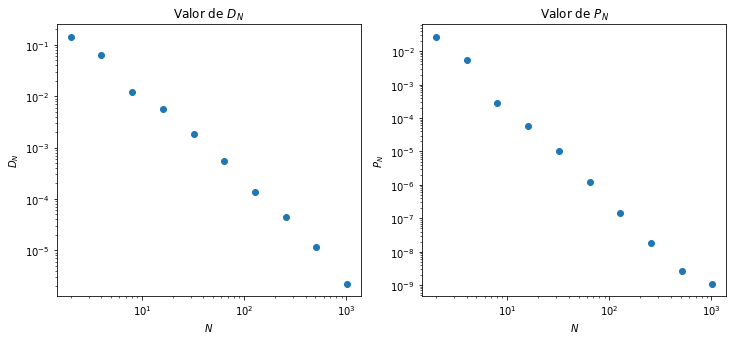

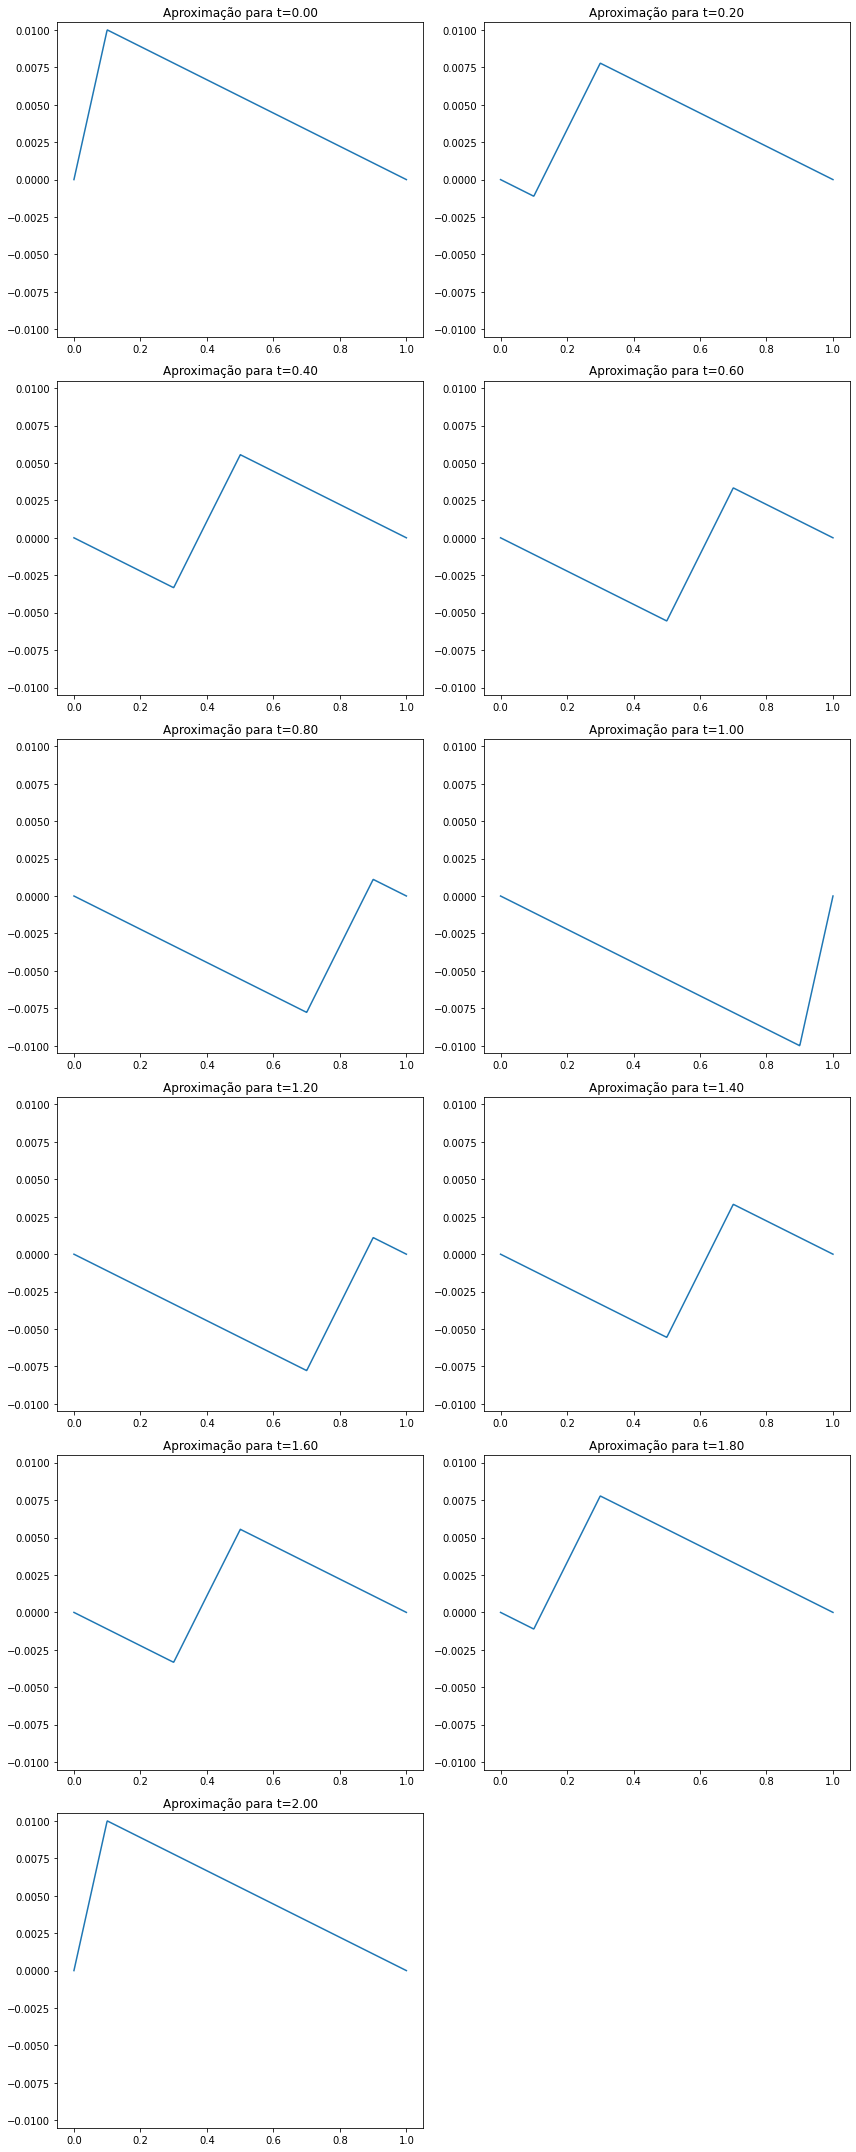

In [47]:
# Função 3.3 no instante 0
L = 1
A = 0.01

def psi330(x: np.ndarray) -> np.ndarray:
    # Determinar em que ramo estamos
    x[x==1] = 0.99999       # Corrigir o caso x = 1 para que fique no 2º ramo
    dec, _ = np.modf(x)

    return np.where(dec <= 0.1, x / 10, (1 - x) / 90 )



def fourier_onda_parada(cn0: float, kn: float) -> Callable:
    """
        Dependência no tempo e no espaço dos coeficientes cn para cn'(0) = 0

        cn0: Valor de cn em t = 0
        kn: Valor de kn
    """
    
    return lambda x, t: -2 * cn0.imag * np.sin(kn * x) * np.cos(kn * t)


def fourier_onda(L: float, M: int, func: Callable, N: int, P: int, T: int, TMax: int, A: float, cnt: Callable) -> None:
    """
        Evolução no tempo de uma onda usando coeficientes de Fourier

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real que descreve a onda no instante inicial
        N: Ordem da aproximação (coeficientes de -N a N)
        P: Número de pontos em x a usar na representação gráfica
        T: Número de pontos em t a usar
        TMax: Instante máximo para representar
        A: Amplitude máxima da onda (apenas afeta a representação grafica)
        cnt: Função a usar para obter c_n(t) cujos argumentos são c0 e de kn
    """

    # Coeficientes da função aproximada
    kn = np.pi * np.arange(0, N+1) / L
    cn = fourier_coef(L, M, func, kn)

    # Evolução no tempo dos coeficientes de Fourier
    cnfunc = np.array([cnt(cn[i], kn[i]) for i in range(0, N+1)])

    # Evolução no tempo da corda
    xx = np.linspace(0, 1, P)
    tt = np.linspace(0, TMax, T)

    # Representar graficamente a evolução no tempo
    A *= 1.05
    cols = 2
    rows = T // cols + 1

    plt.figure(figsize=(6 * cols, 5 * rows))
    for i, t in enumerate(tt):
        # Aproximação de Fourier
        ff = np.array([coef(xx, t) for coef in cnfunc]).sum(axis=0).real

        # Representar graficamente
        plt.subplot(rows, cols, i+1)
        plt.plot(xx, ff)
        plt.title(f"Aproximação para t={t:.2f}")
        plt.ylim(-A, A)

    plt.tight_layout()
    plt.show()

    return


def fourier_erros(L: float, M: int, func: Callable, NMin: int, NMax: int) -> None:
    """
        Representação gráfica das duas formas de medir os erros numa aproximação de Fourier para uma função arbitrária

        L: Período da função func
        M: Número de intervalos usados no método de Simpson (M é par!)
        func: Função real que descreve a onda no instante inicial
        NMin, NMax: Representar o erro de 2**NMin até 2**NMax, percorrendo apenas as potências de 2
    """

    NN = 2 ** np.arange(NMin, NMax)

    df = fourier_desvios(L, M, func, NN)
    pn = fourier_faltam(L, M, func, NN)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(NN, df)
    plt.title("Valor de $D_N$")
    plt.xlabel("$N$")
    plt.ylabel("$D_N$")
    plt.yscale("log")
    plt.xscale("log")

    plt.subplot(1, 2, 2)
    plt.scatter(NN, pn)
    plt.title("Valor de $P_N$")
    plt.xlabel("$N$")
    plt.ylabel("$P_N$")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()


# Escolher N
M = 3000

NMin = 1
NMax = 11

fourier_erros(L, M, psi330, NMin, NMax)


# Parâmetros
T = 11
TMax = 2

N = 512
P = 1000

fourier_onda(L, M, psi330, N, P, T, TMax, A, fourier_onda_parada)


4. Repita o problema anterior com o perfil iniciado dado por
\begin{align}
\psi(x,0)=\frac{L}{100}e^{-\frac{\left(x-L/2\right)^{2}}{2\sigma^{2}}}
\end{align}
com $\sigma=L/20$. Comente o que observa. 

# Resposta 3.4

Temos as mesmas condições fronteira que na alínea acima, pelo que podemos aplicar um raciocínio semelhante.

Simplificamos primeiro a função:

$$
\begin{align*}
\psi(x, 0) &= \frac1{100}e^{-\frac{(x - 1/2)^2}{2(1/20)^2}} =
\\\\
&= \frac1{100}e^{-\left(\frac{x - 1/2}{\sqrt 2(1/20)}\right)^2} =
\\\\
&= \frac1{100}e^{-\left(\frac{20x - 10}{\sqrt 2}\right)^2}
\end{align*}
$$

## Análise dos Resultados
Também temos um período igual a dois pois a frequência fundamental é a mesma que no caso acima.

Tal como no caso acima, o monte é refletido para um vale no extremo fechado, sendo isso ainda mais óbvio neste caso!

Usamos $N=32$ pois a partir desse valor a aproximação deixa de melhorar significativamente.

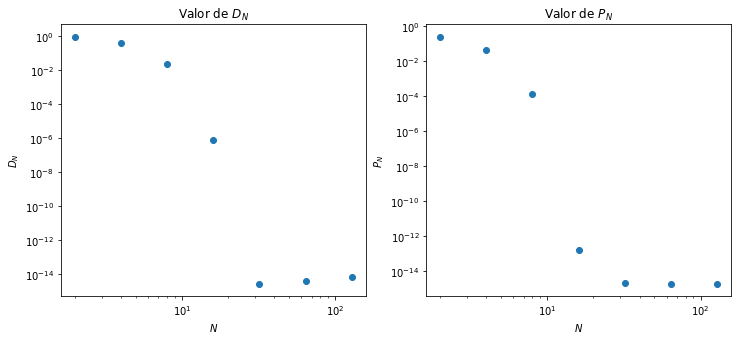

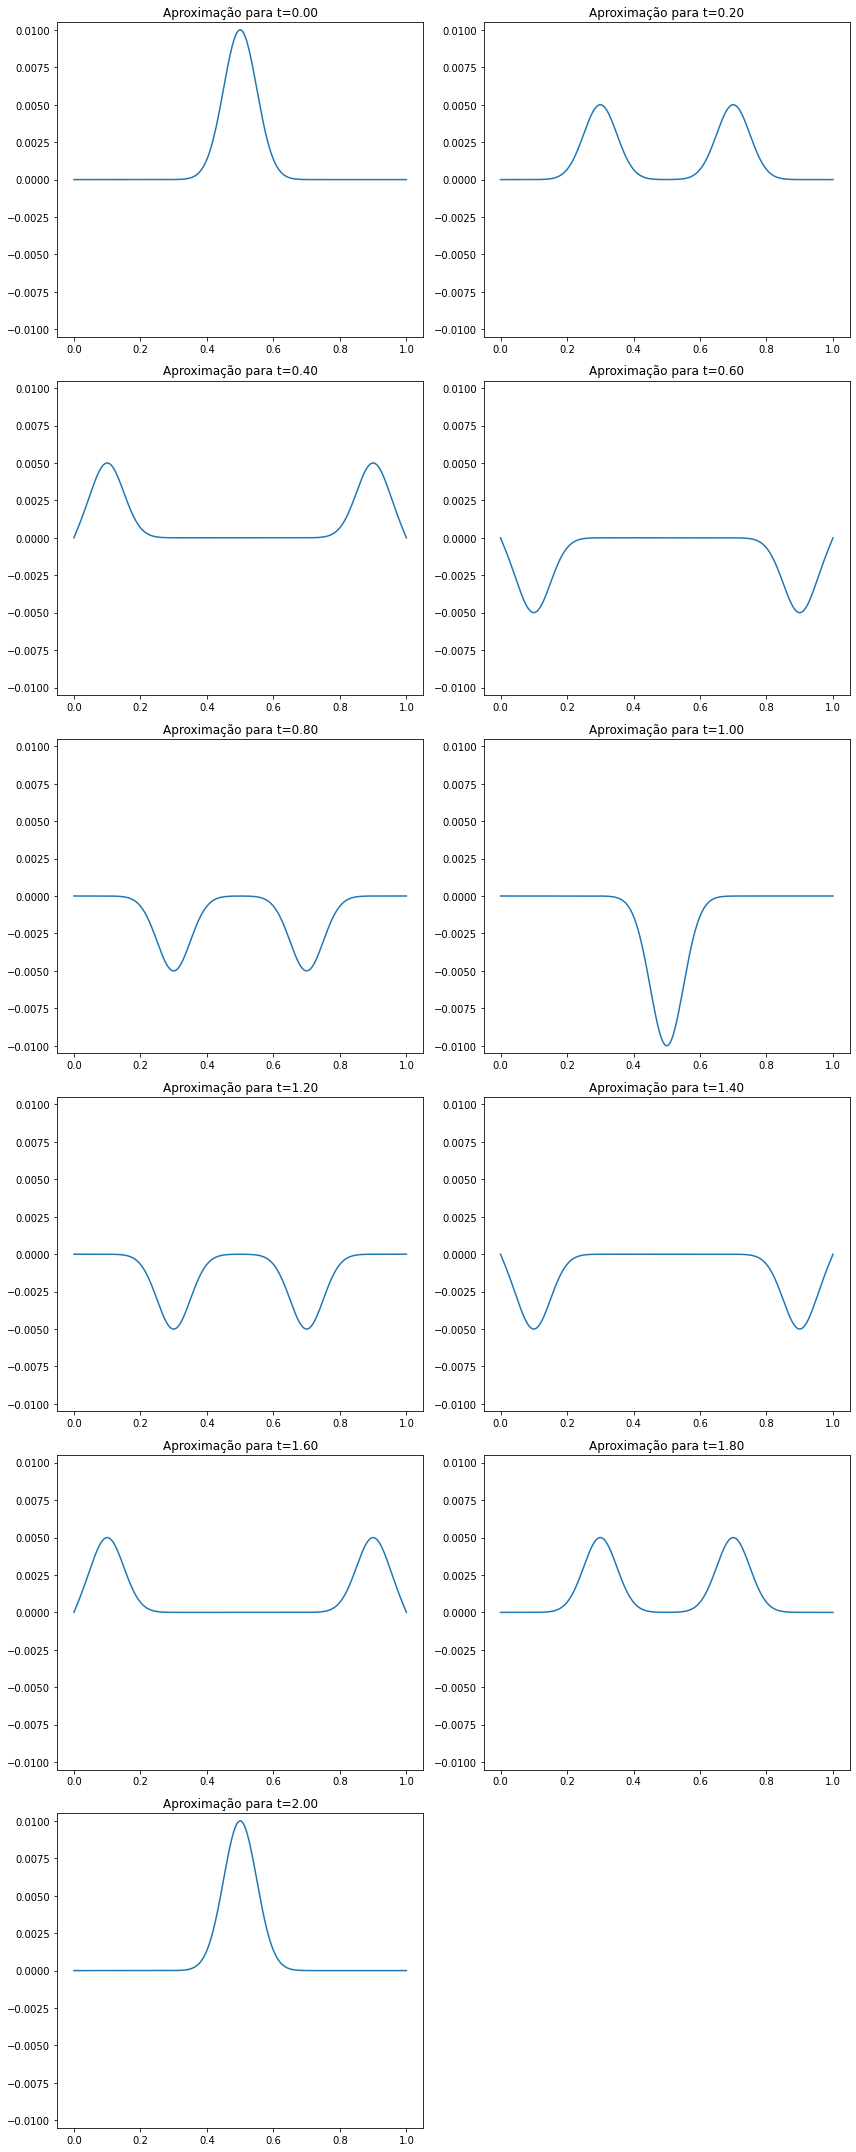

In [48]:
# Função 3.4 no instante 0
L = 1
M = 2500
A = 0.01

def psi340(x: np.ndarray) -> np.ndarray:
    return np.exp(-(20 * x - 10)**2 / 2) / 100

# Escolher N
NMin = 1
NMax = 8

fourier_erros(L, M, psi340, NMin, NMax)


# Parâmetros
T = 11
TMax = 2

N = 32 
P = 1000

fourier_onda(L, M, psi340, N, P, T, TMax, A, fourier_onda_parada)


5. Que condição inicial era preciso escolher para o que o impulso da alínea anterior se mova para a direita? Sugestão: A solução geral da equação de onda é dada por pela combinação linear de duas ondas propagantes 
$\psi(x)=A\tilde{\psi}(x-ct)+B\tilde{\psi}(x+ct)$.

# Resposta 3.5

Vamos voltar ao caso mais geral, em que a corda não está inicialmente parada. Temos na mesma:

$$
\begin{align*}
\psi(x, t) &= \sum_{n=-N}^{N}c_n(t)e^{ik_nx}
\\\\
&= c_0(t) + \sum_{n=1}^{N}c_n(t)e^{ik_nx} + (c_{n}(t)e^{ik_nx})^* =
\\\\
&= c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)e^{ik_nx}\right]
\end{align*}
$$

Aplicamos agora as condições fronteira:

$$
\begin{align*}
\psi(0, t) = 0 &\leftrightarrow c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)e^{ik_n0}\right] = 0
\\\\
&\leftrightarrow c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)\right] = 0
\\\\
&\leftrightarrow c_0(0) + 2\sum_{n=1}^N\text{Re}\left[c_n(0)\cos(k_nt) + \frac{c'_n(0)}{k_n}\sin(k_nt)\right] = 0
\\\\
&\leftrightarrow c_0(0) + 2\sum_{n=1}^N\cos(k_nt)\text{Re}\left[c_n(0)\right] + \frac{\sin(k_nt)}{k_n}\text{Re}\left[c'_n(0)\right] = 0 \rightarrow
\\\\
&\rightarrow c_0(0) = 0\quad\wedge\quad \text{Re}\left[c_n(0)\right] = 0 \quad\wedge\quad \text{Re}\left[c'_n(0)\right] = 0
\\\\\\
\psi(L, t) = 0 &\leftrightarrow c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)e^{ik_nx}\right] = 0 \leftrightarrow
\\\\
&\leftrightarrow 2\sum_{n=1}^N\text{Re}\left[c_n(t)\right]\text{Re}\left[e^{ik_nx}\right] - \text{Im}\left[c_n(t)\right]\text{Im}\left[e^{ik_nx}\right] = 0 \leftrightarrow
\\\\
&\leftrightarrow -2\sum_{n=1}^N\text{Im}\left[c_n(t)\right]\text{Im}\left[e^{ik_nx}\right] = 0 \rightarrow
\\\\
&\rightarrow k_nL = n\pi \leftrightarrow k_n = \frac{n\pi}{L}
\end{align*}
$$

Escolhemos $\text{Im}[c_n(0)] \ne 0$ pois caso contrário obtemos apenas a solução trivial. Podemos então escrever a função que descreve a onda como:

$$
\begin{align*}
\psi(x, t) &= c_0(t) + 2\sum_{n=1}^N\text{Re}\left[c_n(t)e^{ik_nx}\right] =
\\\\
&= -2\sum_{n=1}^N\text{Im}\left[c_n(t)\right]\text{Im}\left[e^{ik_nx}\right] =
\\\\
&= -2\sum_{n=1}^N\left[\text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_nx}\right]\cos(k_nt) + \text{Im}\left[c'_n(0)\right]\text{Im}\left[e^{ik_nx}\right]\frac{\sin(k_nt)}{k_n}\right]
\end{align*}
$$

Vamos agora usar as seguintes relações:
$$
\begin{align*}
e^{ik_n(x + t)} + e^{ik_n(x - t)} &= e^{ik_nx}\left[e^{ik_nt} + e^{-ik_nt}\right] =
\\\\
&= 2e^{ik_nx}\cos(k_nt)
\\\\\\
e^{ik_n(x + t)} - e^{ik_n(x - t)} &= e^{ik_nx}\left[e^{ik_nt} - e^{-ik_nt}\right] =
\\\\
&= 2ie^{ik_nx}\sin(k_nt)
\end{align*}
$$

Podemos então escrever:

$$
\begin{align*}
\psi(x, t) &= -\sum_{n=1}^N\left[\text{Im}\left[c_n(0)\right]\text{Im}\left[2e^{ik_nx}\cos(k_nt)\right] + \text{Im}\left[c'_n(0)\right]\text{Im}\left[2e^{ik_nx}\sin(k_nt)\right]\frac{1}{k_n}\right] =
\\\\
&= -\sum_{n=1}^N\left[\text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_n(x + t)} + e^{ik_n(x - t)}\right] + \text{Im}\left[c'_n(0)\right]\text{Im}\left[\frac{e^{ik_n(x + t)}}i - \frac{e^{ik_n(x - t)}}i\right]\frac{1}{k_n}\right] =
\\\\
&= -\sum_{n=1}^N\left[\text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_n(x + t)}\right] + \text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_n(x - t)}\right] + \text{Im}\left[c'_n(0)\right]\text{Im}\left[-ie^{ik_n(x + t)}\right]\frac{1}{k_n} - \text{Im}\left[c'_n(0)\right]\text{Im}\left[-ie^{ik_n(x - t)}\right]\frac{1}{k_n}\right] =
\\\\
&= -\sum_{n=1}^N\left[\text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_n(x + t)}\right] + \text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_n(x - t)}\right] - \text{Im}\left[c'_n(0)\right]\text{Re}\left[e^{ik_n(x + t)}\right]\frac{1}{k_n} + \text{Im}\left[c'_n(0)\right]\text{Re}\left[e^{ik_n(x - t)}\right]\frac{1}{k_n}\right] =
\\\\
&= -\sum_{n=1}^N\left[\text{Im}\left[c_n(0)\right]\sin\left[k_n(x + t)\right] + \text{Im}\left[c_n(0)\right]\sin\left[k_n(x - t)\right] - \text{Im}\left[c'_n(0)\right]\cos\left[k_n(x + t)\right]\frac{1}{k_n} + \text{Im}\left[c'_n(0)\right]\cos\left[k_n(x - t)\right]\frac{1}{k_n}\right]
\end{align*}
$$

Para eliminarmos a componente que se desloca para a esquerda temos que impor a seguinte condição adicional:

$$
\begin{align*}
\text{Im}\left[c_n(0)\right]\text{Im}\left[e^{ik_n(x + t)}\right] - \text{Im}\left[c'_n(0)\right]\text{Re}\left[e^{ik_n(x + t)}\right]\frac{1}{k_n} = 0 &\leftrightarrow \text{Im}\left[c'_n(0)\right] = k_n\text{Im}\left[c_n(0)\right]\tan\left[k_n(x + t)\right]
\end{align*}
$$

Como os coeficientes não podem depender de $x$ ou de $t$ chegamos a uma expressão que apenas é válida no caso da solução trivial $c_n(t) = 0$. Percebo que devo ter cometido algum erro de raciocínio pois é possível termos um dado perfil a viajar inicialmente para a direita!

Ainda assim, podemos retirar algum valor desta dedução representando graficamente as componentes progressivas da onda que estudamos acima!

## Análise dos Resultados

Podemos perceber que a soma das ondas progressivas aqui representadas permite recuperar a onda da alínea anterior!

Componente que viaja para a direita:


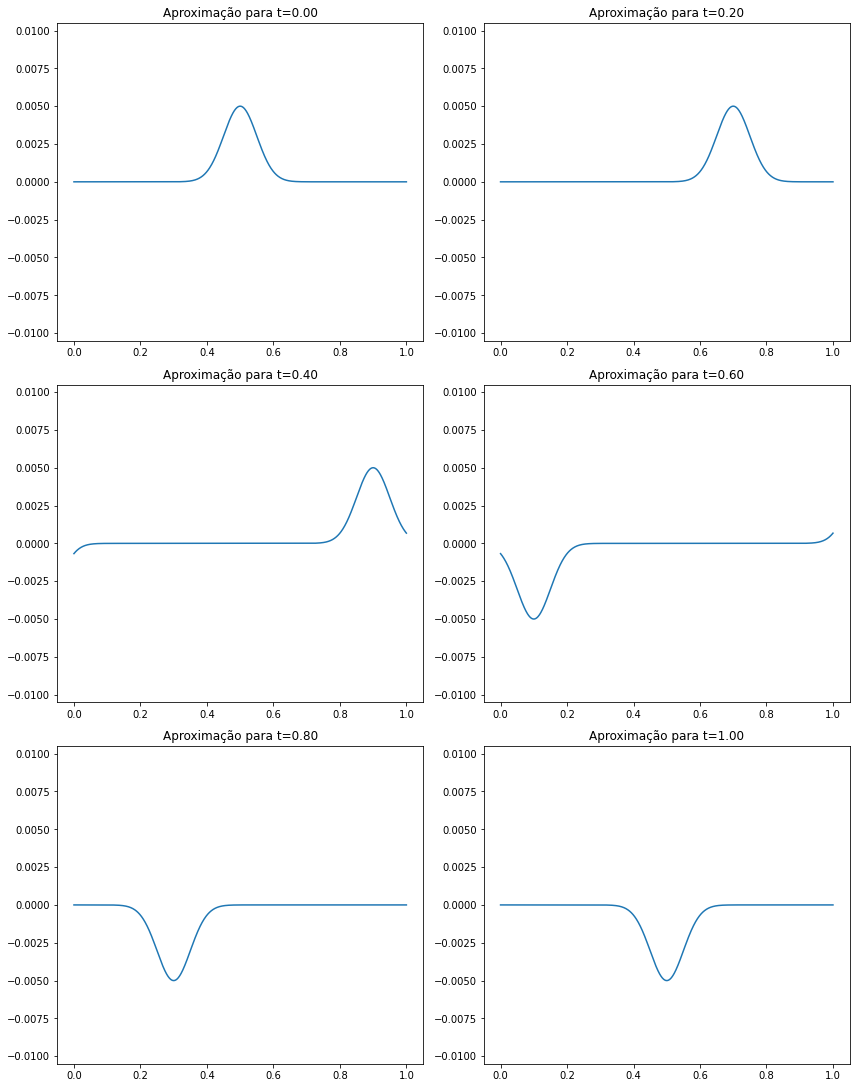

Componente que viaja para a esquerda:


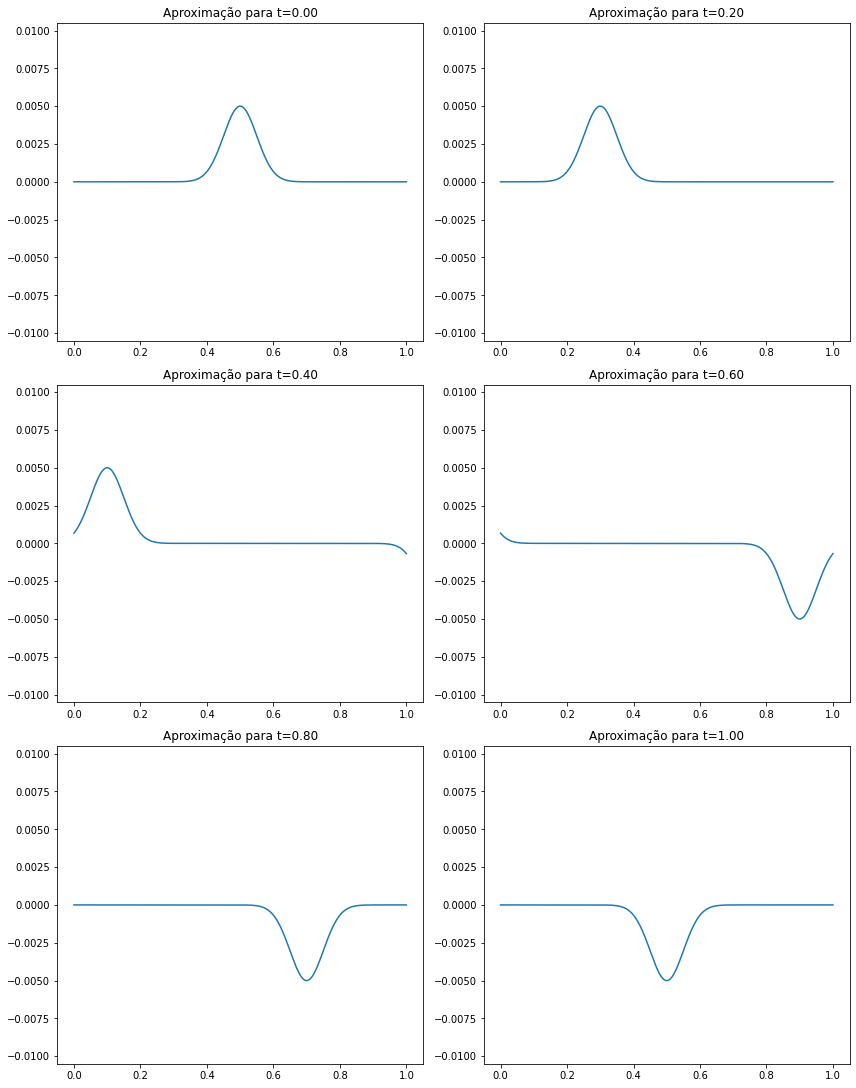

In [49]:
# Componente que viaja para a direita
def fourier_onda_direita(cn0: float, kn: float) -> Callable:
    """
        Dependência no tempo e no espaço dos coeficientes cn

        cn0: Valor de cn em t = 0
        kn: Valor de kn
    """
    
    return lambda x, t: -cn0.imag * (np.sin(kn * (x-t)))


# Componente que viaja para a esquerda
def fourier_onda_esquerda(cn0: float, kn: float) -> Callable:
    """
        Dependência no tempo e no espaço dos coeficientes cn

        cn0: Valor de cn em t = 0
        kn: Valor de kn
    """
    
    return lambda x, t: -cn0.imag * (np.sin(kn * (x+t)))


# Parâmetros
T = 6
TMax = 1

N = 32 
P = 1000

print("Componente que viaja para a direita:")
fourier_onda(L, M, psi340, N, P, T, TMax, A, fourier_onda_direita)

print("Componente que viaja para a esquerda:")
fourier_onda(L, M, psi340, N, P, T, TMax, A, fourier_onda_esquerda)


<div style="border:1px solid black;">
<span style="color:red; font-weight:bold;">Nota:</span> Escreva aqui
<br><div style="color:red; font-weight:bold;">Comentário:</div> Escreva aqui</div>
<div style="border:1px solid black;">
<span style="color:red; font-weight:bold;">Nota:</span> 1
<br><div style="color:red; font-weight:bold;">Comentário:</div> Expressão corretamente adimensionalizada. Na alínea 2 as expressões obtidas encontram-se corretas. Na alínea 3, um pequeno reparo que faria seria na parte em que se utiliza '$c_{-n}(t)=(c_n(t))^*$' mencionar que isto se verifica se a função para a qual se está a calcular os coeficientes de Fourier for real. O resto da alínea foi bem explicado e tem um resultado que faz sentido. Na alínea 4 foi aplicado o mesmo raciocínio para uma função de onda diferente, correndo o código de forma rápida e tendo o resultado esperado. Na alínea 5, não se conseguiu chegar ao resultado esperado. Uma sugestão para resolver o problema seria seguir a sugestão na questão e encontrar uma relação entre $\tilde{\psi}(x-ct)$ e $\tilde{\psi}(x+ct)$ e depois encontrar forma de anular a componente $\tilde{\psi}(x+ct)$, que é a que contribui para o movimento se fazer para a esquerda. Globalmente bem executado.</div>


Bom Trabalho